# Detecting Toxic Text with Embeddings and Support Vector Machines.
This notebook is a fun exploration into text embeddings and SVMs, which goes with the [associated blog post](example.com) on my [blog](https://willmatthews.xyz).

## Motivation
This is my first post in a series of monthly machine learning projects.
The motivation for this project is to get started using text embeddings (which are fundamentally very interesting!) and attempt my idea of using SVMs to classify different passages of text.

Content moderation is a nontrival problem. Bayesian statistics get you quite far, but you eventually encounter things like the [Scunthorpe Problem](https://en.wikipedia.org/wiki/Scunthorpe_problem) which are false positives. You may also encounter people subverting moderation filters (using spaces / symbols to space out a rude word). A better way is needed, and embeddings may offer that pathway.

## Embeddings
In this project, we use text embeddings to train a classifier on.
Embeddings, in general, are a learned representation of a piece of data. A high-dimensional, or complicated piece of data is compressed into a lower-dimensional form, typically a vector (or sometimes a matrix in the case of convnets).
These can be trained using something like an autoencoder:

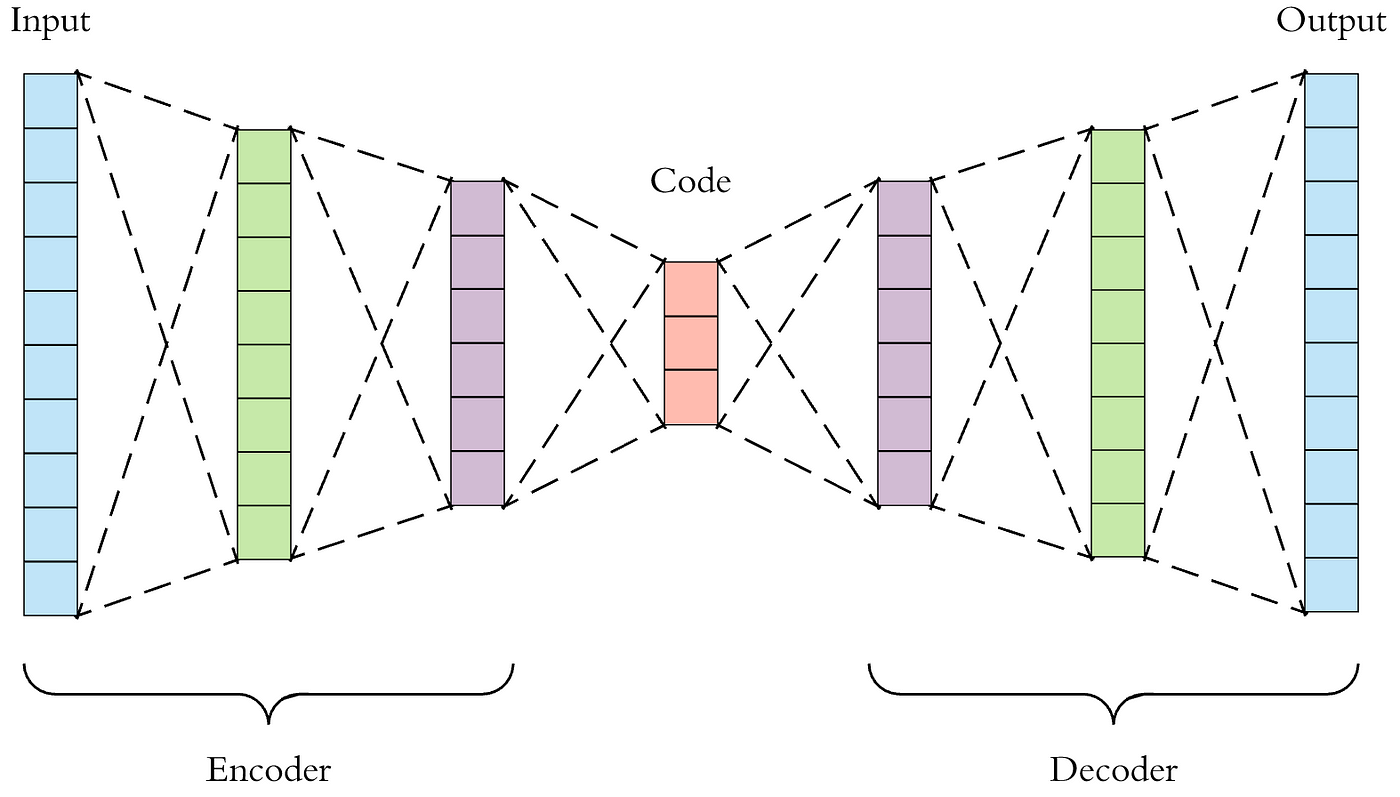

Which, if simplified, looks something like this:
$$thing \rightarrow \text{hidden layers} \rightarrow embedding \rightarrow \text{hidden layers} \rightarrow thing'$$
The error is defined as the difference between the thing and the reconstructed thing, $error = (thing'-thing)$.
We then train the model with many examples of the data we are trying to encode, minimising the error.
Once you have trained this autoencoder, you cut it in half, and keep only the encoder.

If you're doing this yourself, you need to be careful at this point. Your model is *only effective for cases the model can interpolate for*. What I mean by this is if you train an autoencoder on images of cats and dogs, it'll be very effective at representing images of cats and dogs in an embedding. If you decide to put a picture of a walrus into it, the embedding will likely not be a good one and the autoencoder will likely fail to reconstruct the walrus.

Because the autoencoder is able to compress a piece of data into a learned representation, and then decompress it back into approximately the same data, an infintesmal change in the embedding will not change the output. In fact, slowly changing a feature of the embedding will slowly, smoothly, change the output. This nice feature means that similar objects are close together, and this feature is one which this entire notebook hinges on.

A text embedding is similar to what I have already introduced, it is a projection into a high-dimensional latent space of a piece of text.
Text embeddings come from language models, and encode the meaning of tokens (and their ordering) into a vector.
If you want to know more about text embedding specifically, [the stack overflow blog post on them](https://stackoverflow.blog/2023/11/09/an-intuitive-introduction-to-text-embeddings/) is quite a good way to get up to speed.
The way they are made is a bit more involved than just an autoencoder, but this is outside the scope of this notebook.

Embeddings capture many, many features of text, and in truth they are more powerful than what we need here.
As mentioned earlier, the feature of embeddings which we want to leverage is that similar things are close together.
Hopefully, we can leverage this fact by assuming that 'toxic' text is close together, and can be therefore easily separated from normal text.

## Embeddings: Running a model locally
There is [a leaderboard](https://huggingface.co/spaces/mteb/leaderboard) which ranks the performance of different text embedding models.
For the sake of this notebook, we need to be able to embed some text, however, I'd lke to be able to do it:
1. For free (this rules out using OpenAI)
2. With low compute requirements (Some models are huge and require GPUs)
3. With a small memory requirement
4. In a 'FOSS-y way' (You should be able to run this on your own hardware *entirely*, with open weights)

After scouring the leaderboard, I decided to pick [nomic-ai/nomic-embed-text-v1](https://huggingface.co/nomic-ai/nomic-embed-text-v1). I chose this model as (as of 15/02/2024) it is 19th on the MTEB leaderboard.
It also has:
- Open Weights
- A max sequence length of 8192 (as high as you could ever need)
- A model size of 550 MB (This is not bad! #1's size is 14 GB)
- An embedding in 768 dimensions

In [1]:
# Import everything required for this notebook
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from openai import OpenAI

import pandas as pd
import numpy as np
import time
import seaborn as sns

from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

We now use the example using transformers (the huggingface module), as described on [the nomic embedding webpage](https://huggingface.co/nomic-ai/nomic-embed-text-v1).

In [2]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('nomic-ai/nomic-embed-text-v1', trust_remote_code=True)
model.eval()
_ = model

<All keys matched successfully>


In [3]:
def embed_texts(passages):
    encoded_input = tokenizer(passages, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        model_output = model(**encoded_input)
    
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings

Just for the sake of testing, curiosity, and driving the point that similar texts create embeddings which are close together; we can define the *similarity* between two embeddings, which is the dot product of normalised embeddings.
This is sometimes called *cosine similarity*, because it fundamentally tells you the cosine of the angle between the two vectors (in the high-dimensional space they exist).

In [4]:
def similarity(veca, vecb):
    maga, magb = 0, 0
    dotprod = 0
    for a,b in zip(veca, vecb):
        maga += a*a
        magb += b*b
        dotprod += a*b
    mag = (maga*magb)**0.5
    return dotprod/mag

And now, we can test this with two phrases about my aching arm (I fell on it in a tram station in Norway, I'm fine, don't worry about me, but I think I may have broken a bone in my elbow).

In [5]:
embed_examples = embed_texts(["My arm really hurts!", "my arm is absolutely killing me."])
print(embed_examples)

tensor([[ 0.0074,  0.0264, -0.0228,  ..., -0.0449, -0.0275, -0.0158],
        [ 0.0197,  0.0266, -0.0103,  ..., -0.0223, -0.0374, -0.0619]])


In [6]:
similarity(embed_examples[0], embed_examples[1])

tensor(0.8147)

Cool!
With this result we are able to calculate how similar two pieces of text are.
To wrap this bit of work up, the more relevant two pieces of text are, the higher the similarity. Similarity is scored in the interval [-1, 1],
We've demonstrated we can easily create them, so it is time to do something interesting and useful with them!

For the sake of a curious example, I thought it would be fun to create a detector for toxicity in text.
I don't have a dataset of toxic or clean text easily to hand, and I don't really want toxic text on my GitHub profile, so I considered the option of synthetically generating it.

## Making FakeData with Ollama
Ollama, a really easy way of [running a local LLM](https://ollama.com/), has recently [gained compatability with the OpenAI API](https://ollama.com/blog/openai-compatibility).
In this notebook I'm going to use this, as I want a little bit more flexibility than is offered by models available online, and also don't want to pay for OpenAI models.

What I mean by flexibility , specifically, is that I need to synthetise toxic/mean messages.
LLMs are usually extremely sanitised, and normally refuse the task.
To skirt around this, I need an uncensored model. Uncensored models generally are more obedient (citation needed), however we may need additional tricks to coax it into doing what we want. The flavour of model I use for this notebool is `mistral-openorca`, which I use for all fake data synthesis.

Once ollama is [installed](https://ollama.com/download/linux), which is a very easy affair, ([better instructions](https://github.com/ollama/ollama/blob/main/docs/linux.md) here for power-users), and an ollama server is running (good practise to [daemonise it](https://github.com/ollama/ollama/blob/main/docs/linux.md#adding-ollama-as-a-startup-service-recommended)), the `mistral-openorca` model can be obtaiend by doing `ollama pull mistral-openorca`.

From here, we should be able to connect to it on port 11434!

Ollama should detect your GPU if you have one. If not, it'll run on your CPU. It'll be slower, but still free!

In [7]:
# connect to ollama local API
client = OpenAI(
    base_url = 'http://localhost:11434/v1',
    api_key='ollama', # required, but unused
)

def get_completion(messages):
    response = client.chat.completions.create(
      model="mistral-openorca",
      messages=messages
    )
    return response

def unpack(resp):
    return resp.choices[0].message.content

To make it easier to goad our LLM into doing our bidding, we can trick it with an example.
This is what it means in research to have an "n-shot" (for n greater than zero) prompt.
We have a previous shot (a fake previous response) which makes the LLM more likely to follow our prompts (as it 'believes' it has previously responded to our requests).

In this case, I found that a single shot was enough to make `mistral-openorca` follow my formatting guidelines and request for toxic content.

In [8]:
# Here we do a "one-shot" which gives the LLM a hint at what it should output with an example.
# This tends to make our output conform better to what we want, and reduces the risk of hallucination.
messages = [
        {"role": "system", "content": "You are a helpful assistant, which generates fake messages."},
        {"role": "user", "content": "Generate three messages from someone who is being helpful."},
        {"role": "assistant", "content": "1. I'd love to help! Just tell me what you need and I'll get right to it.\n2. No problem at all mate, just send me the files and I'll start editing them, just to confirm, you do want me to check only for typos and grammatical errors?\n3. Absolutely, I'll just get the car from the garage, I'd be more than happy to drive you to the hospital."},
        {"role": "user", "content": "Generate 30 messages from someone who is being toxic."}
    ]

start = time.time()
response = get_completion(messages)
stop = time.time()
elapsed = stop-start
print(round(response.usage.total_tokens/elapsed,2), "tokens per second")

40.14 tokens per second


The token rate is quite nice for a cheap RTX 2060 Super!
Now we just need to split the generated messages into individual examples.
To achieve this, we assume that the output format of the generated messages is going to be the same as the format hinted by the previous shot.
We can then split by newline, and remove the line start number.

In [9]:
def numbered_to_list(messages):
    out = []
    for msg in messages.split("\n"):
        text = ".".join(msg.split(".")[1:])
        text = text[1:] # strip leading space
        out.append(text)
    return out

In [10]:
numbered_to_list(unpack(response))[3:6]

["You know what, I don't even want to help you anymore. I'm done with being nice about this.",
 'Everything is your fault anyway. You never learn.',
 "Maybe it's time for a change of scenery, and you should take responsibility for your own actions!"]

Those are pretty horrible - exactly what we want for our synthetic toxic dataset!
Now that we can sucessfully 


In [11]:
def generate_dataset(group="normal", number=30):
    prompt = "Generate " + str(number) + " messages "
    if group == "normal":
        prompt += "from someone who is being normal."
    if group == "toxic":
        prompt += "from someone who is being mean."
        # someone who is being a unfriendly, a prick, a fuckhead, an asshole, a twat

    prompt +=  " Emulate communication over instant messaging."
    messages = [
            {"role": "system", "content": "You are a helpful assistant, which generates fake messages."},
            {"role": "user", "content": "Generate three messages from someone who is being helpful."},
            {"role": "assistant", "content": "1. I'd love to help! Just tell me what you need and I'll get right to it.\n2. No problem at all mate, just send me the files and I'll start editing them, just to confirm, you do want me to check only for typos and grammatical errors?\n3. Absolutely, I'll just get the car from the garage, I'd be more than happy to drive you to the hospital."},
            {"role": "user", "content": prompt}
        ]
    
    response = get_completion(messages)
    return numbered_to_list(unpack(response))

And now, we create our test and train data.

In [12]:
print("Generating fake data")
standard_train = generate_dataset()
print("Standard train Done, generated", len(standard_train), "examples")
standard_test = generate_dataset()
print("Standard test Done, generated", len(standard_test), "examples")
toxic_train = generate_dataset("toxic")
print("Toxic train Done, generated", len(toxic_train), "examples")
toxic_test = generate_dataset("toxic")
print("Toxic test Done, generated", len(toxic_test), "examples")

Generating fake data
Standard train Done, generated 30 examples
Standard test Done, generated 30 examples
Toxic train Done, generated 39 examples
Toxic test Done, generated 3 examples


So we can generate fakedata, how very exciting!
We are now at a stage where we have training and test examples of normal messages, and ones where the sender is being toxic.

Additionally, we developed the ability to embed our text into a high-dimensional latent space. The act of doing this hand-waves a lot of the hard NLP work away: we now have vector representations of our data which we can work with in more "traditional" ML methods.
Now at this interesting point, we should try to see if it's possible to predict if some text is toxic.

## Classification

What we said sounds remakably like a battle-cry to make a classifier, so let's create one!

### Support Vector Machines

#### What are they?

A Support Vector Machine (SVM) is a sophisticated and adaptable supervised machine learning algorithm utilised for both classification and regression tasks.
It works by identifying the hyperplane that optimally separates different classes within the feature space.
The objective of the SVM is to maximise the margin between the nearest points of the classes, which are referred to as support vectors.
This method aids in achieving robust generalisation for unseen data.
SVMs can manage data that is linearly separable as well as non-linearly separable by employing kernel functions, enabling them to project the data into higher-dimensional spaces where a linear separator is feasible.
Owing to its efficiency in handling high-dimensional data and its capability to model complex nonlinear relationships, SVM is extensively applied in various fields, including image recognition, bioinformatics, and text categorisation.

#### Why use them?

SVMs are well-suited to the problem of working with embeddings for multiple reasons:
- **High Dimensionality Handling:** SVMs excel in high-dimensional spaces, making them suitable for dense embeddings from sparse data.
- **Effective Margin Maximisation:** By maximising the margin between classes, SVMs ensure robust decision boundaries in the embedding space.
- **Versatility with Kernel Trick:** The kernel trick allows SVMs to classify non-linearly separable data in embeddings.
- **Sparse Data Efficiency:** SVMs perform efficiently with dense representations from embeddings, improving computational performance.
- **Generalisation to Unseen Data:** SVMs generalise well on embeddings, enhancing accuracy in predictive tasks.
- **Scalability with Selected Features:** Dimensionality reduction via embeddings helps SVMs scale to large datasets while maintaining performance.

### Other Classification Methods

In the interest of impartiality, other classification methods are available.
- **Logistic Regression:** Efficient for binary classification tasks, even with high-dimensional data like embeddings.
- **Decision Trees:** Capable of handling complex datasets by learning hierarchical, non-linear relationships.
- **Random Forests:** An ensemble method that improves on decision tree performance by reducing overfitting and increasing accuracy.
- **Gradient Boosting Machines (GBMs):** Sequentially build weak models, typically decision trees, to improve classification outcomes progressively.
- **Neural Networks:** Especially deep learning models, can learn intricate patterns from embeddings for both binary and multi-class classification.
- **k-Nearest Neighbors (k-NN):** A non-parametric method that classifies based on the majority vote of the nearest neighbours in the embedding space.
- **Naive Bayes:** Applies Bayes’ theorem with the “naive” assumption of independence between every pair of features, suitable for text and other embeddings.
- **Ensemble Methods (e.g., AdaBoost, Voting Classifiers):** Combine multiple models to improve classification accuracy, leveraging the strengths of various approaches.


We start by constructing test and train datasets which are numpy arrays.

`x_test` and `x_train` are the raw text we want to do our classification tasks on.

`e_test` and `e_train` are the text embeddings, the feature vectors we are running the SVM on.

`y_test` and `y_train` are ground truth labels which are `0` for `non-toxic` and `1` for `toxic`.

In [13]:
x_train = np.concatenate((standard_train, toxic_train))
y_train = np.concatenate(([0 for _ in standard_train], [1 for _ in toxic_train]))

x_test = np.concatenate((standard_test, toxic_test))
y_test = np.concatenate(([0 for _ in standard_test], [1 for _ in toxic_test]))

e_train = embed_texts(list(x_train))
e_test = embed_texts(list(x_test))

Now with the data sets, we train the SVM classifier (`clf`) with `clf.fit(e_train, y_train)`.

Immediately, we can score how succesful the classifier is by predicting what classes `e_test` would imply!
The predictions are stored in `y_test`.

We use the kernel trick to allow for nonlinear prediction boundaries.
Finally, we use `probability=True` on the definition of the classifier, as we want to be able to have a metric for the strength of our predictions.

In [14]:
clf = svm.SVC(kernel="rbf", probability=True)
clf.fit(e_train, y_train)

y_pred = clf.predict(e_test)
probs = clf.predict_proba(e_test)

clf.score(e_test,y_test)

0.9696969696969697

Thrilling! Our naive SVM has an accuracy of > 90% on our dataset. Let's drill-down into the prediction probabilities so we can better understand how good our SVM is.

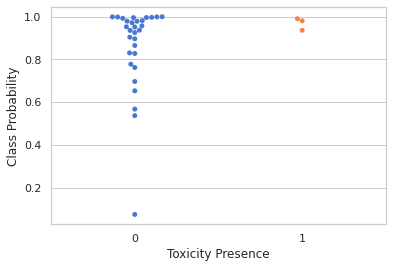

In [15]:
sns.set_theme(style="whitegrid", palette="muted")

# Load the dataset
messages = pd.DataFrame()
messages["category"] = y_test
messages["prob_category"] = [p[y] for p, y in zip(probs, y_test)]
messages["text"] = x_test

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(data=messages, x="category", y="prob_category")
ax.set(xlabel="Toxicity Presence")
ax.set(ylabel="Class Probability")
_ = ""

In this plot, for each class, the probability of the prediction being that class is plotted.
For an ideal performing classifier we would expect all points to be near 1.0.

However, we see that in this case (where there are two classifiers) , some points go under 50% correct class prediction probability and may be mis-classed.
The tails on these distributions seem very long, and this may be due to the fishily generated dataset.

To see a bit more clearly what is going on, we can utilise a confusion matrix, which will show the frequency of prediction correctness.

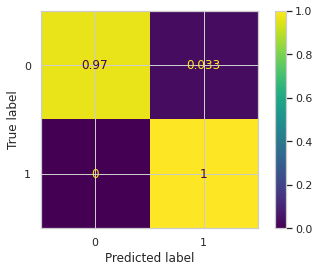

In [16]:
cm = confusion_matrix(y_test, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Not bad at all! For the case where there is no toxicity present, we rarely incorrectly classify the text as toxic (a type 2 error).
For the case where we have toxic messages, A small percentage of our dataset snuck through as predicted 'non-toxic'.

In fact, let's examine the least probable points for each class.

In [17]:
threshold = 0.7

for index, x in messages.iterrows():
    if x["prob_category"] < threshold:
        print(x["category"], x["prob_category"], x["text"])

0 0.07524383972081475 Wow, that sounds really interesting! I'm curious, did you find the learning curve pretty steep?
0 0.6964446449106108 Omg, what a wild ride that was! Haha, can't believe it actually happened.
0 0.6528140147362708 Oh wow, that sounds like a fantastic opportunity! I hope you enjoy every moment of it. 
0 0.567320004196918 That's amazing, I've always admired that skill! Hopefully one day, I can pick up something new too!
0 0.5369243985354875 Oh wow, you should be really proud of yourself! That's an awesome accomplishment and you totally deserve it!


Subjectively, some of these may not match the class they are labelled, which means that our performance may even be better than what our confusion matrix suggest.
I admit that there are issues with the way I generate my dataset.
The real name of the game would be to trial this out on a larger, curated dataset with better labelling (and perhaps more classes!).

Interestingly, sarcasm seems to be fooling the classifier!
This somewhat makes sense, and future work would be needed to deal with the problems sarcasm brings (a sarcasm detector?).

This is outside of the scope for now, I wanted to present the fact we can classify text using embeddings, but a better dataset will feature in a future post.

## Conclusion and Future Work

Hopefully, I have been able to convince you that you can roll your own classifiers on text embeddings.
Being able to do this is really convenient, as naively asking a LLM to classifiy your data is exceptionally expensive and comes with added latency.
Text embeddings, for all practical purposes, can be regarded as free (we made them at zero cost in this notebook!) and then running a SVM is for all purposes free too.

It is non-trivial to get a full solution for toxic text detection correct (what about sarcasm? what about people joking about? what if a message lacks context from earlier on?), but this shows it's exceptionally easy to get 80% of the way there.

A real benefit of this method is that you can define your own classes (provided you have a well-labelled set).
It feels like the only hurdle, as with most ML problems, is getting enough training data.

### Future Work

- Consider how to determine if piece of text is sarcastic.
- Consider if embeddings be used with a wider context? How may this work?
- Are there other inexpensive classifiers which work well?
    - Logistic Regression?
    - Random forest?
    - kNN?
- Did I use the best kernel trick?
- How much does more training data help?
- What is the quality of the output from synthetic generation? Can it be improved?
- Can we cluster text automatically with EM?